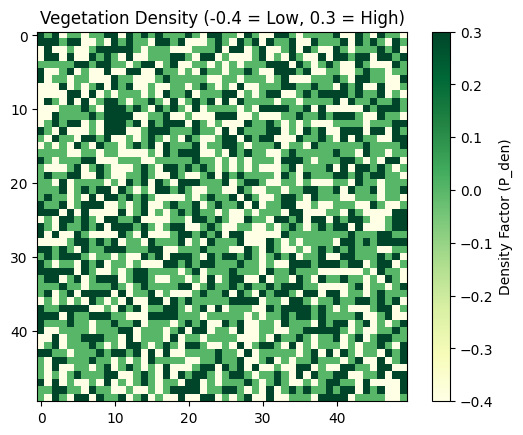

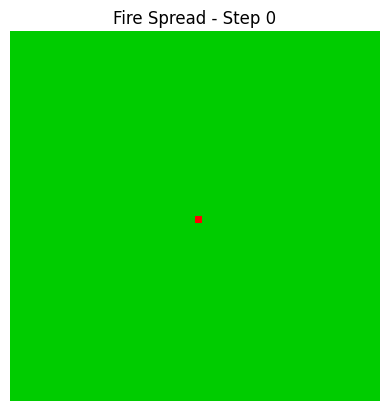

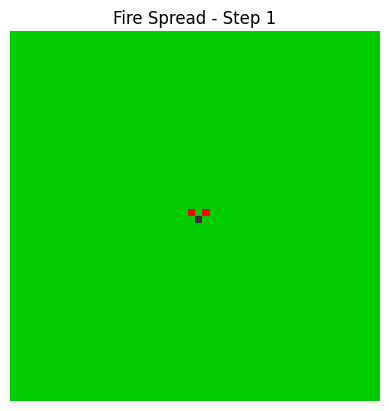

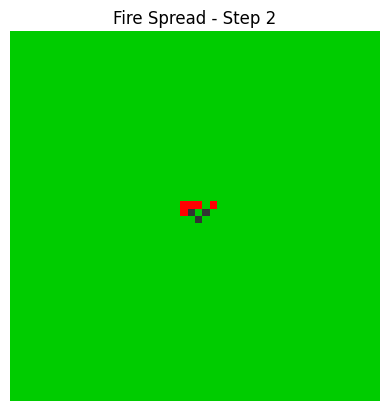

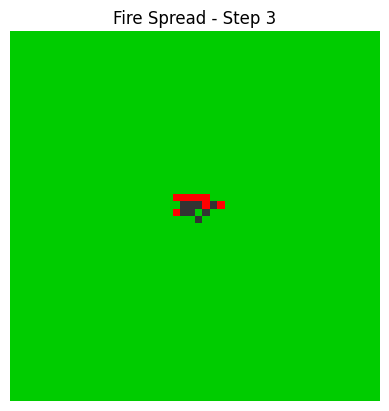

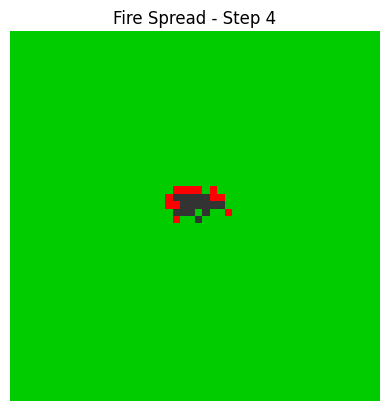

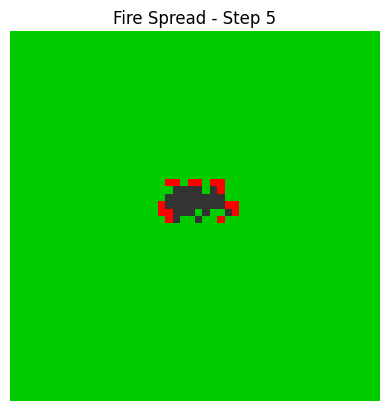

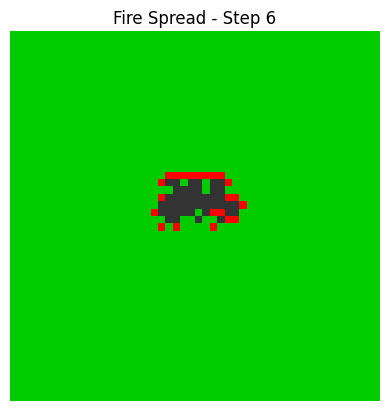

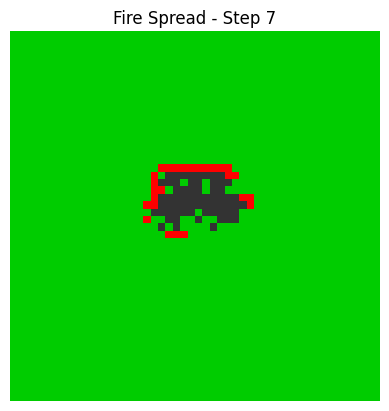

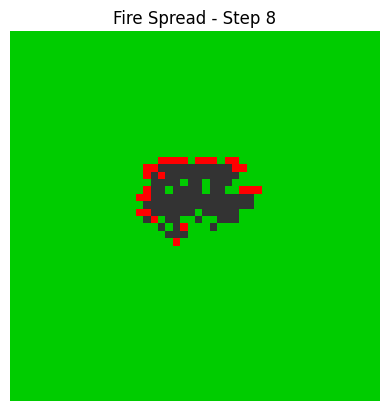

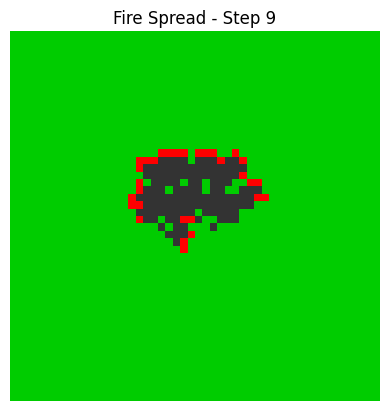

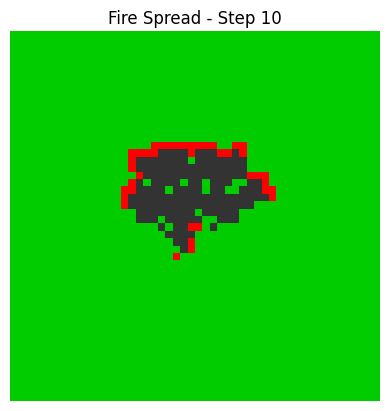

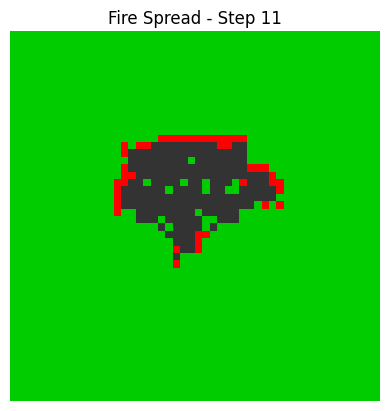

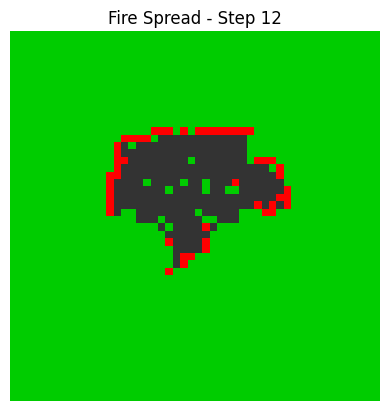

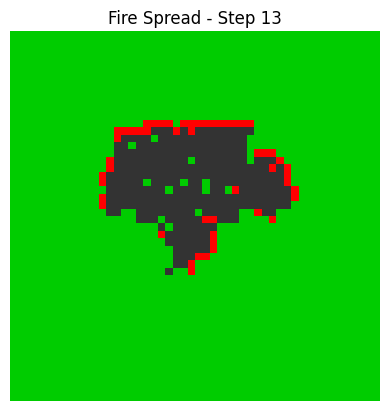

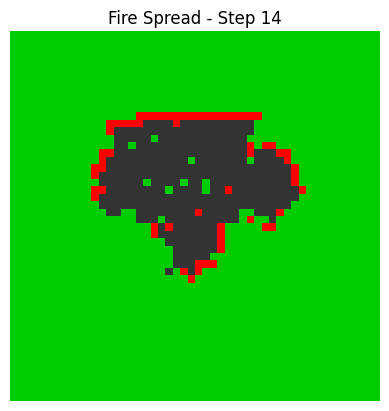

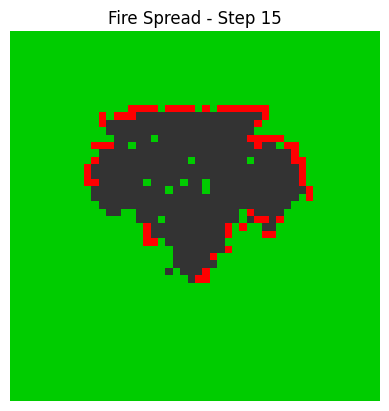

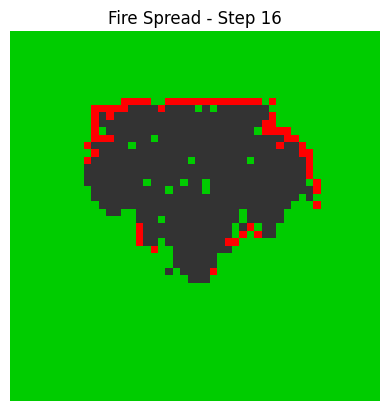

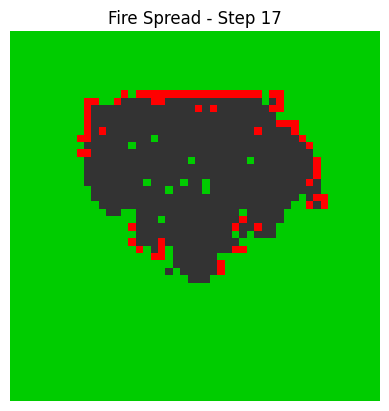

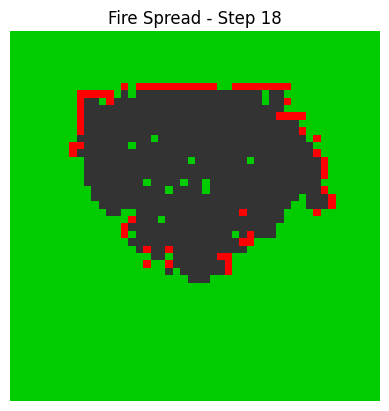

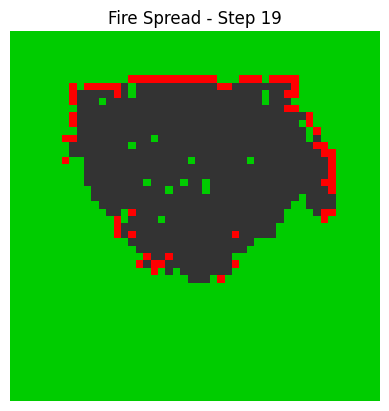

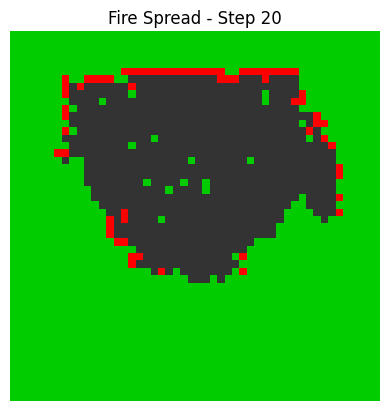

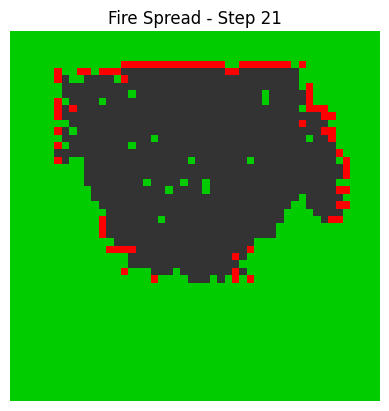

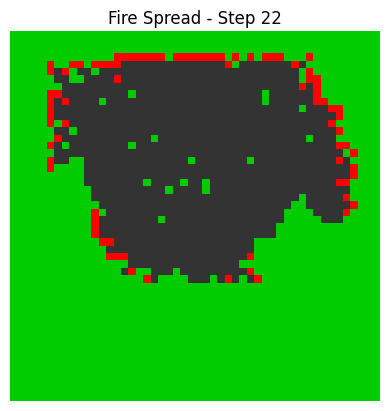

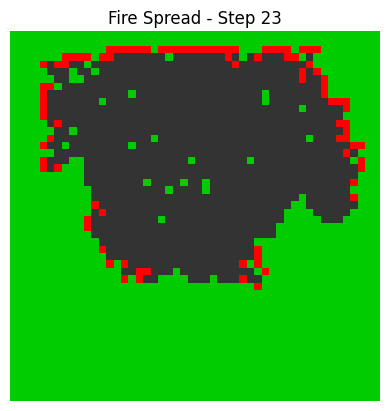

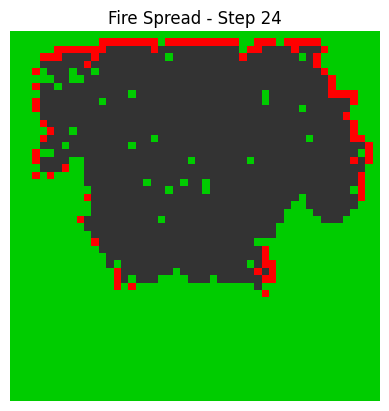

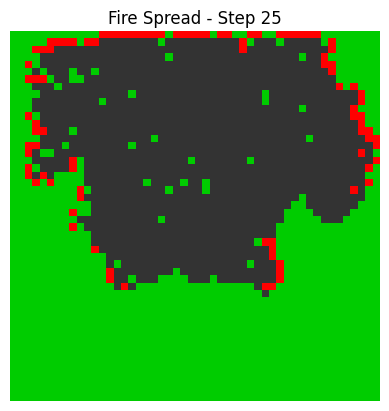

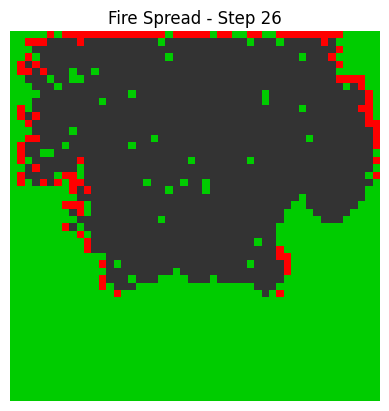

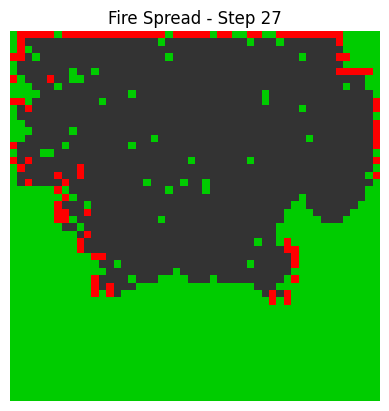

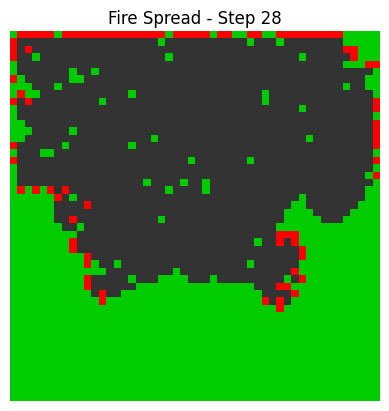

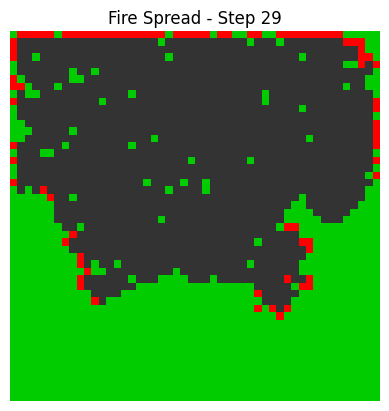

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define states
EMPTY = 0
FUEL = 1
BURNING = 2
BURNED = 3

# Grid setup
grid_size = 50
grid = np.ones((grid_size, grid_size)) * FUEL
grid[grid_size // 2, grid_size // 2] = BURNING  # Initial fire in the center

# 1. Vegetation density map: values -0.4 (low), 0.0 (medium), 0.3 (high)
density_map = np.random.choice([-0.4, 0.0, 0.3], size=grid.shape, p=[0.3, 0.4, 0.3])

# 2. Wind parameters (assumed constant for now)
wind_speed = 5
wind_dir = 0  # North

# 3. Compute wind factor with vegetation density
def compute_fire_probability(wind_speed, fire_dir, wind_dir, P_den):
    theta = np.radians(fire_dir - wind_dir)
    Pw = np.exp(0.045 * wind_speed) * np.exp(wind_speed * 0.131 * (np.cos(theta) - 1))
    P0 = 0.58
    return P0 * (1 + P_den) * Pw

# 4. Fire update logic
def update_fire(grid):
    new_grid = grid.copy()
    for i in range(1, grid.shape[0] - 1):
        for j in range(1, grid.shape[1] - 1):
            if grid[i, j] == BURNING:
                new_grid[i, j] = BURNED
                for dx, dy, direction in [(-1, 0, 0), (-1, 1, 45), (0, 1, 90), (1, 1, 135),
                                          (1, 0, 180), (1, -1, 225), (0, -1, 270), (-1, -1, 315)]:
                    ni, nj = i + dx, j + dy
                    if grid[ni, nj] == FUEL:
                        P_den = density_map[ni, nj]
                        prob = compute_fire_probability(wind_speed, direction, wind_dir, P_den)
                        if np.random.rand() < prob:
                            new_grid[ni, nj] = BURNING
    return new_grid

# 5. Plotting function
def plot_grid(grid, step):
    colors = {
        EMPTY: (1.0, 1.0, 1.0),    # white
        FUEL: (0.0, 0.8, 0.0),     # green
        BURNING: (1.0, 0.0, 0.0),  # red
        BURNED: (0.2, 0.2, 0.2)    # dark gray
    }
    rgb_grid = np.zeros((*grid.shape, 3))
    for state, color in colors.items():
        rgb_grid[grid == state] = color
    plt.imshow(rgb_grid)
    plt.title(f"Fire Spread - Step {step}")
    plt.axis('off')
    plt.show()

# 6. Show the vegetation density map
plt.imshow(density_map, cmap="YlGn", interpolation="nearest")
plt.title("Vegetation Density (-0.4 = Low, 0.3 = High)")
plt.colorbar(label="Density Factor (P_den)")
plt.show()

# 7. Run the simulation
steps = 30
for step in range(steps):
    plot_grid(grid, step)
    grid = update_fire(grid)
    if np.count_nonzero(grid == BURNING) == 0:
        break  # Stop if no more burning cells


In [ ]:
!pip install rasterio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 98.2 MB/s eta 0:00:00


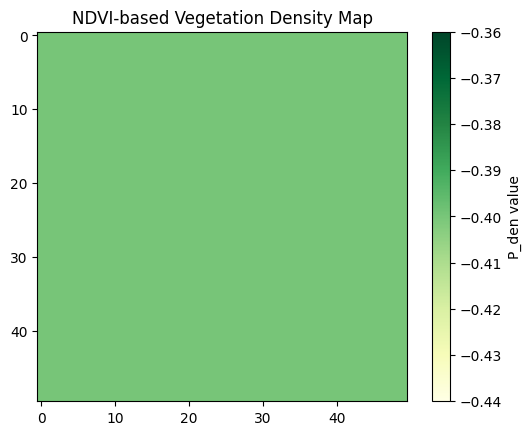

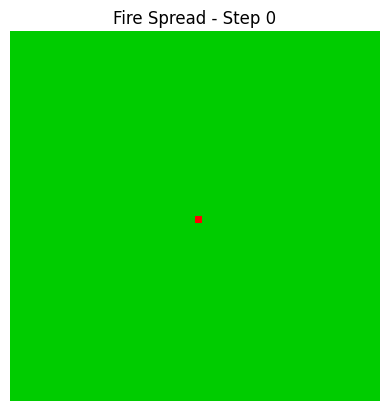

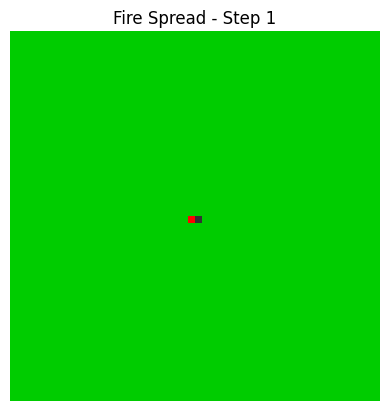

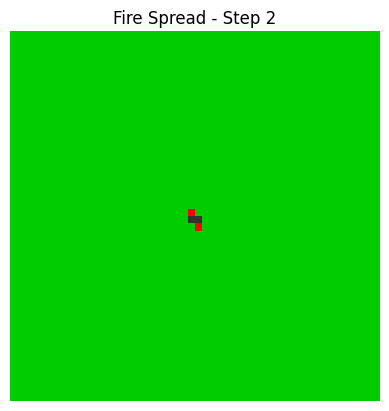

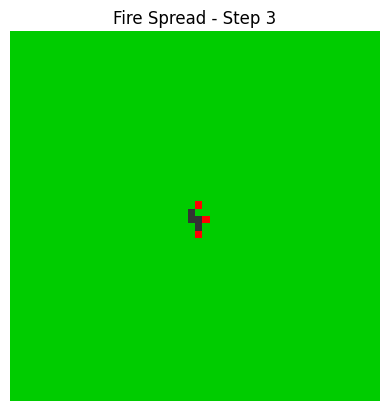

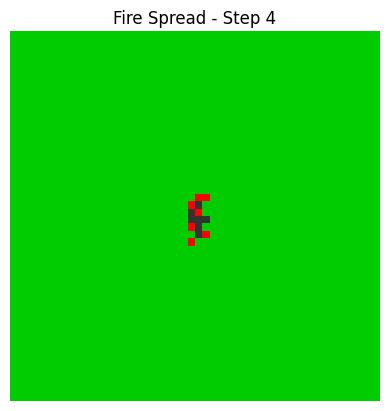

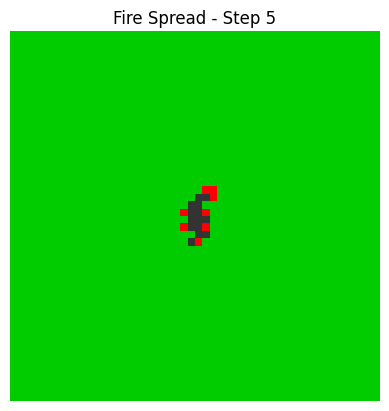

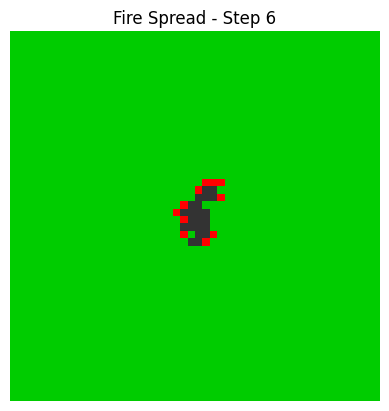

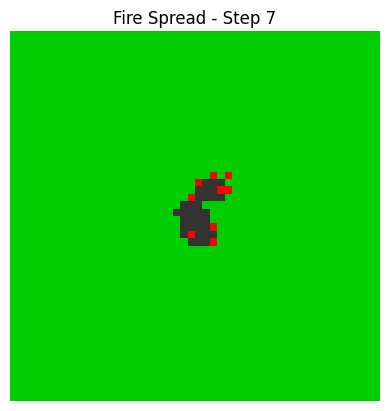

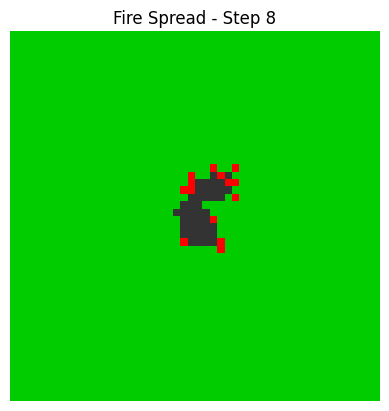

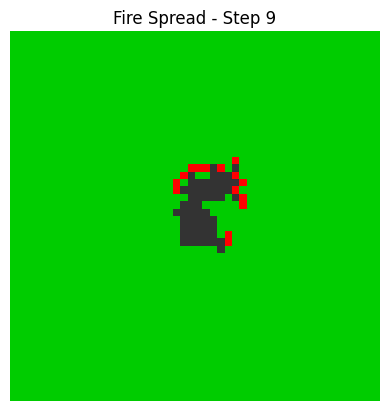

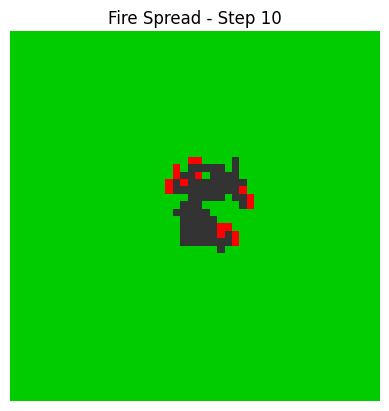

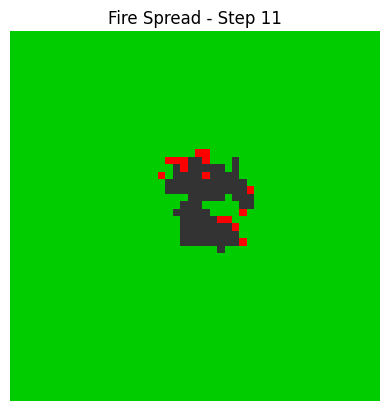

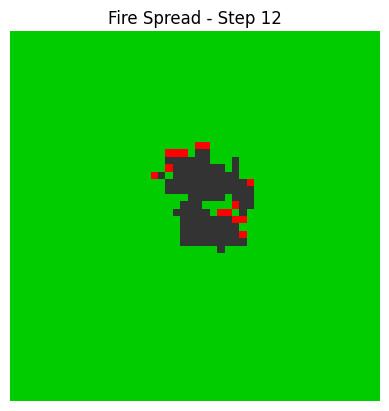

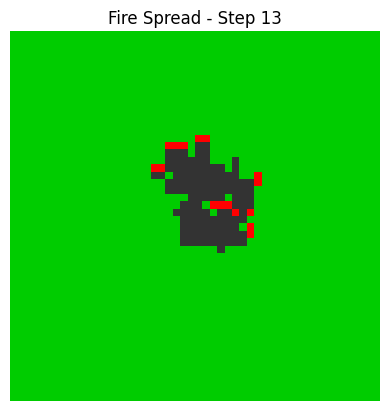

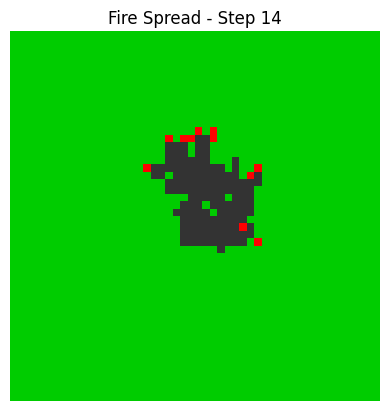

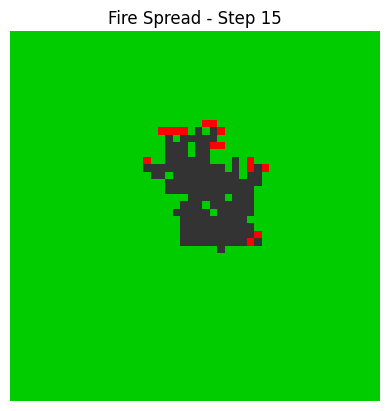

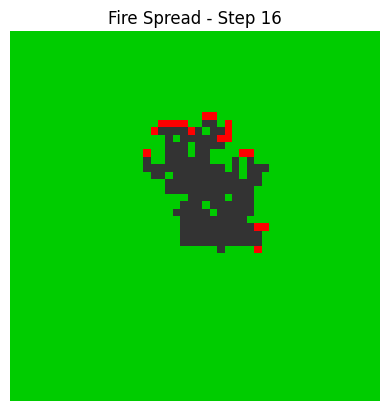

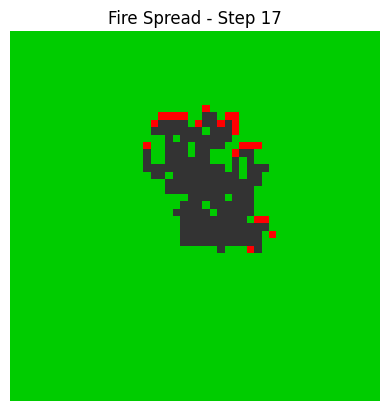

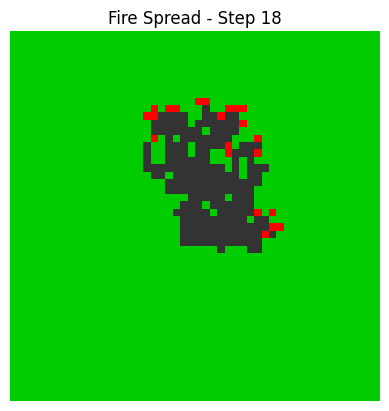

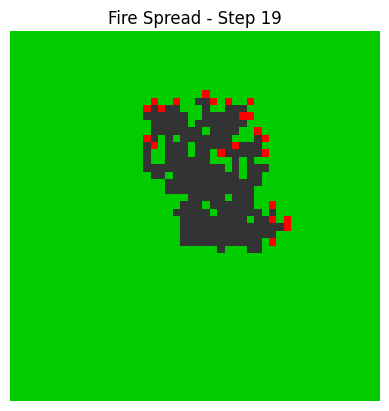

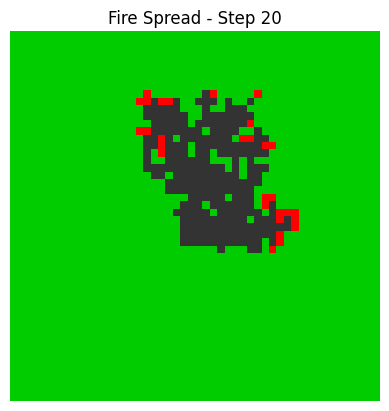

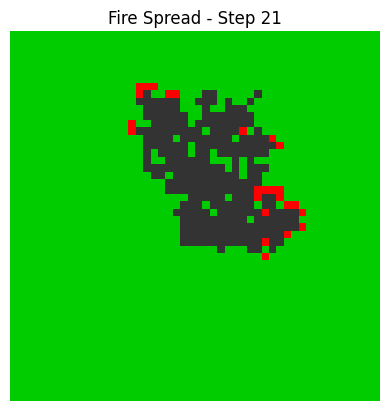

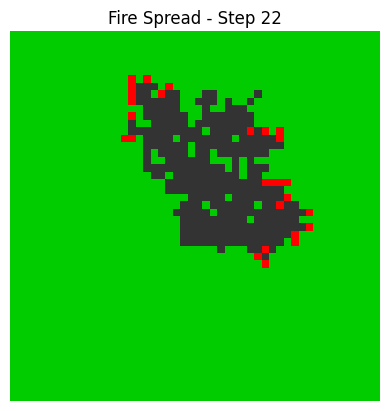

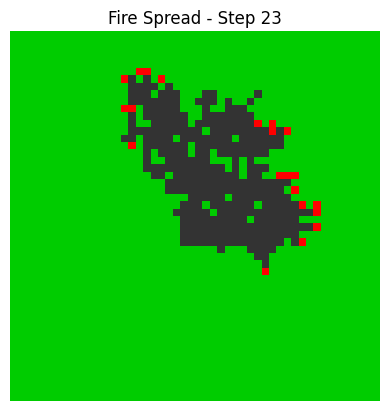

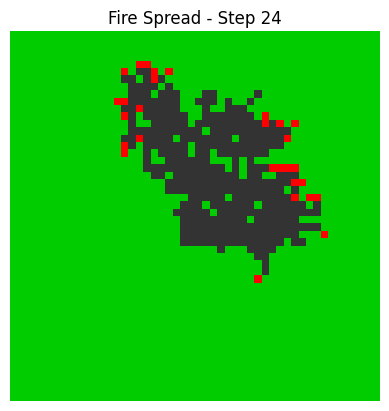

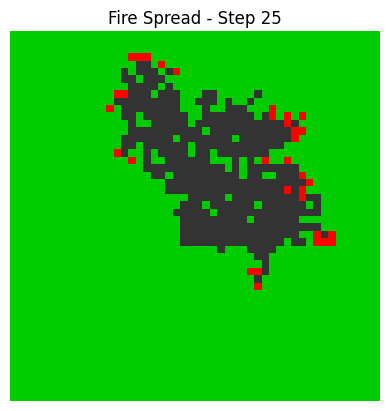

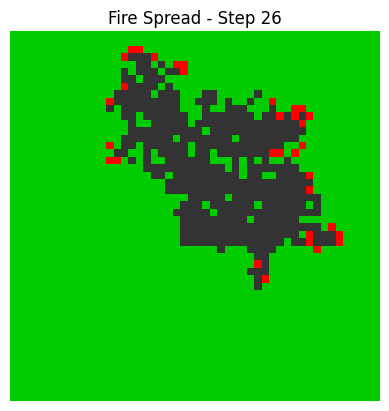

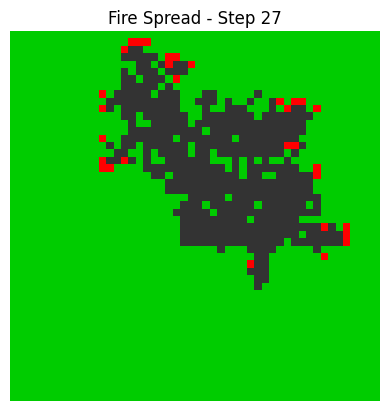

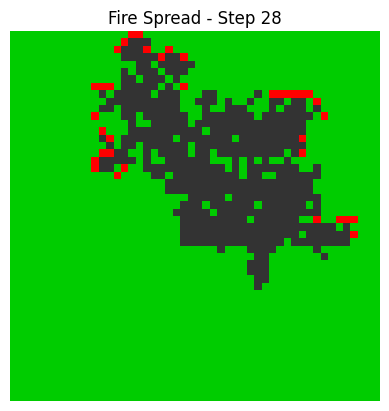

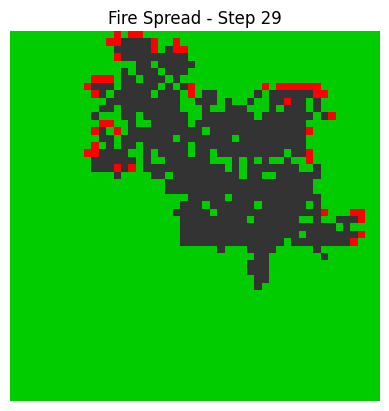

In [7]:
# Install dependencies (only needed once)
!pip install rasterio scikit-image

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.transform import resize

# --- Simulation Parameters ---
GRID_SIZE = 50  # Size of the fire grid
STEPS = 30      # Number of time steps to simulate
WIND_SPEED = 5  # m/s
WIND_DIR = 0    # degrees (0 = north)

# --- State Constants ---
EMPTY = 0
FUEL = 1
BURNING = 2
BURNED = 3

# --- Fire Spread Probability (with wind and vegetation density) ---
def compute_fire_probability(wind_speed, fire_dir, wind_dir, P_den):
    theta = np.radians(fire_dir - wind_dir)
    Pw = np.exp(0.045 * wind_speed) * np.exp(wind_speed * 0.131 * (np.cos(theta) - 1))
    P0 = 0.58
    return P0 * (1 + P_den) * Pw

# --- Load and Preprocess NDVI from sample_data ---
with rasterio.open("/content/sample_data/CA_VEG_Sentinel2_NDVI.tif") as src:
    ndvi = src.read(1)
    ndvi = np.where(ndvi == src.nodata, np.nan, ndvi)

# Normalize NDVI (adjust if already scaled)
ndvi = ndvi / 10000.0

# --- Classify NDVI into Vegetation Density ---
def classify_density(ndvi_val):
    if np.isnan(ndvi_val):
        return 0.0
    elif ndvi_val < 0.2:
        return -0.4
    elif ndvi_val < 0.5:
        return 0.0
    else:
        return 0.3

density_map = np.vectorize(classify_density)(ndvi)

# --- Resize to Match Fire Grid ---
density_map_resized = resize(density_map, (GRID_SIZE, GRID_SIZE), mode='reflect', preserve_range=True)

# Optional: Visualize density map
plt.imshow(density_map_resized, cmap="YlGn")
plt.title("NDVI-based Vegetation Density Map")
plt.colorbar(label="P_den value")
plt.show()

# --- Fire Grid Initialization ---
grid = np.ones((GRID_SIZE, GRID_SIZE)) * FUEL
grid[GRID_SIZE // 2, GRID_SIZE // 2] = BURNING  # Start fire in center

# --- Cellular Automata Fire Spread ---
def update_fire(grid, density_map):
    new_grid = grid.copy()
    for i in range(1, grid.shape[0] - 1):
        for j in range(1, grid.shape[1] - 1):
            if grid[i, j] == BURNING:
                new_grid[i, j] = BURNED
                for dx, dy, direction in [(-1, 0, 0), (-1, 1, 45), (0, 1, 90), (1, 1, 135),
                                          (1, 0, 180), (1, -1, 225), (0, -1, 270), (-1, -1, 315)]:
                    ni, nj = i + dx, j + dy
                    if grid[ni, nj] == FUEL:
                        P_den = density_map[ni, nj]
                        prob = compute_fire_probability(WIND_SPEED, direction, WIND_DIR, P_den)
                        if np.random.rand() < prob:
                            new_grid[ni, nj] = BURNING
    return new_grid

# --- Plot Fire Grid ---
def plot_grid(grid, step):
    colors = {
        EMPTY: (1.0, 1.0, 1.0),    # white
        FUEL: (0.0, 0.8, 0.0),     # green
        BURNING: (1.0, 0.0, 0.0),  # red
        BURNED: (0.2, 0.2, 0.2)    # dark gray
    }
    rgb_grid = np.zeros((*grid.shape, 3))
    for state, color in colors.items():
        rgb_grid[grid == state] = color
    plt.imshow(rgb_grid)
    plt.title(f"Fire Spread - Step {step}")
    plt.axis('off')
    plt.show()

# --- Run the Simulation ---
for step in range(STEPS):
    plot_grid(grid, step)
    grid = update_fire(grid, density_map_resized)
    if np.count_nonzero(grid == BURNING) == 0:
        print(f"Simulation stopped at step {step}: fire is out.")
        break

